# Random Forests

This notebook uses RFs to synthesize data. Main point summarized:
- Sample from marginal distributions in all features to create a data set "fake"
- Train a RF to differentiate real from fake
- Check which fake observations seem real
- Generate more fake data, classify and keep only those classified as real, to build up a synthetic data set

This follows work by Dalya Baron, found on [GitHub](https://github.com/dalya/WeirdestGalaxies)

Perhaps later on:
- Check resulting marginal distribution functions
- Adjust synthetic data set to morph into desired marginal distributions
- Use the metrics of Jim Achterberg to check on Goodness-of-Fit and perhaps Privacy conservation (by construction?)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

### A very simple data set
Just the 4 features of iris.

In [2]:
X_real, y_real = load_iris(return_X_y=True)
real_data = pd.DataFrame(X_real) 
real_data['target'] = y_real
real_data.head()

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


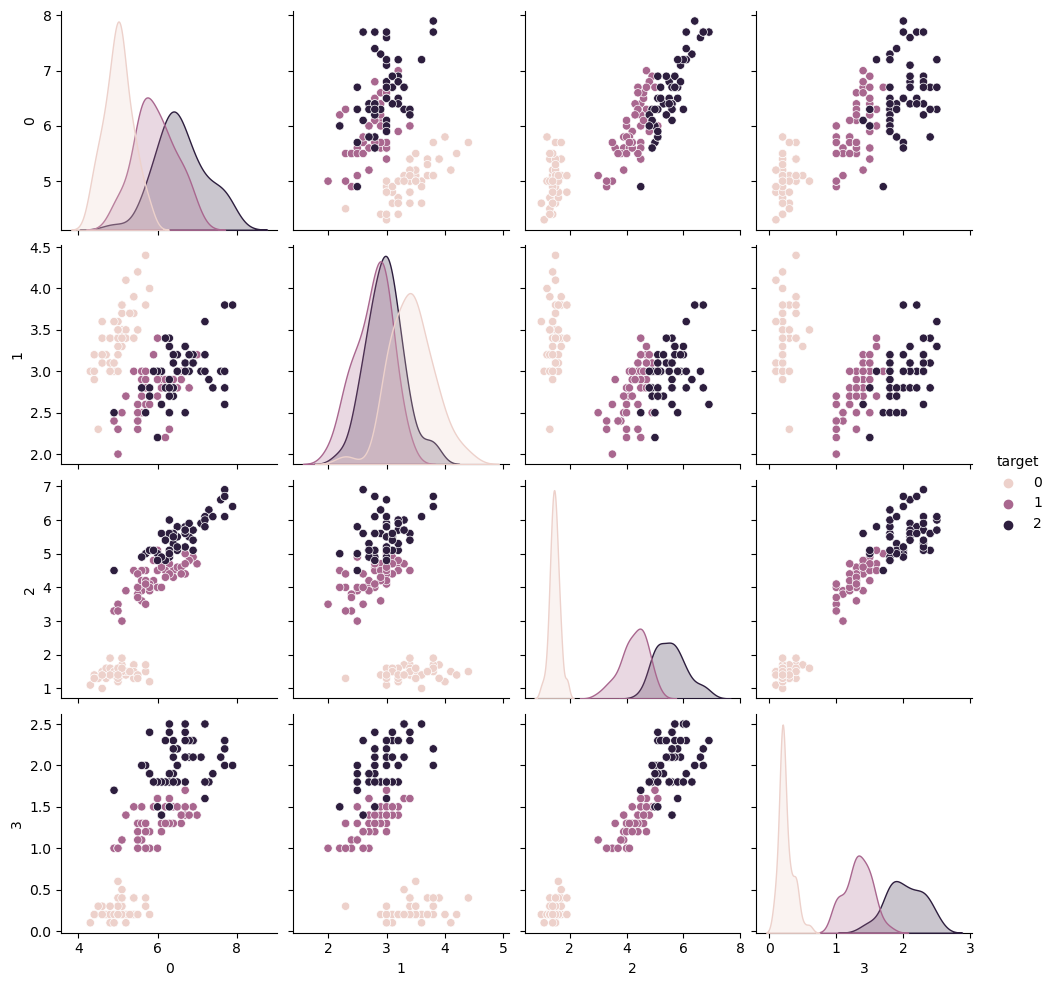

In [33]:
sns.pairplot(real_data, vars=[0,1,2,3], hue='target');

### General-use functions

In [9]:
def sample_marginal(X, sample_size=None):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    
    If sample_size = None: same length as X, otherwise: sample_size
    """
    xshape = X.shape
    features = xshape[1]

    if not sample_size: sample_size = xshape[0]
    X_syn = np.zeros((sample_size, xshape[1]))

    for i in range(features):
        obs_vec = X[:,i]
        X_syn[:,i]  = np.random.choice(obs_vec, sample_size) # here we chose the synthetic data to match the marginal distribution of the real data
        
    return X_syn

def merge_real_fake(X_r, X_f):
    """
    The function merges the data into one sample, 
    giving the label "0" to the real data and label "1" to the synthetic data
    """
    # build the labels vector
    Y_r = np.zeros(len(X_r))
    Y_f = np.ones(len(X_f))

    Y_total = np.concatenate((Y_r, Y_f))
    X_total = np.concatenate((X_r, X_f))
    return X_total, Y_total


def synthesize(orig_data, 
               nsynth, 
               label_predictor=None, 
               as_frame=False
              ):
    """ Synthesize data based on orig_data, with sample size nsynth.
    Data can be returned as np.ndarray (default) or pd.DataFrame (as_frame=True).
    
    If a label_predictor is supplied, it will, in case of a dataframe as output, 
    predict the labels of the synthetic data as well.    
    """
       
    # Create fake data to train discriminator    
    X_fake = sample_marginal(orig_data)
    X, y = merge_real_fake(orig_data, X_fake)
    
    # Discriminator
    discriminator = RandomForestClassifier(
        n_estimators=100, 
        max_depth=3, 
        min_samples_leaf=5, 
        min_samples_split=5
       )
    
    # Predict and estimate the fraction of "realistic" data points sampled
    discriminator.fit(X, y)
    y_pred = discriminator.predict(X)[int(len(y)/2):]
    frac_real = 2* (y_pred == 0).sum() / orig_data.shape[0]
    
    # Prepare synthestic data
    shape = (nsynth, orig_data.shape[1])
    X_synth = np.zeros(shape)

    # Synthesize!
    synth_size = 0
    while synth_size < nsynth:
        X_s = sample_marginal(orig_data, sample_size=int(X_synth.shape[0]/frac_real))
        y_s = discriminator.predict(X_s)
        n_OK = (y_s == 0).sum() 
        too_many = np.max((n_OK + synth_size - nsynth, 0))
        looking_real = X_s[(y_s == 0),:]
        if too_many == 0:
            X_synth[synth_size:synth_size+n_OK,:] = looking_real
        else:
            X_synth[synth_size:synth_size+n_OK-too_many,:] = looking_real[:-too_many,:]
        synth_size += n_OK

    if as_frame:
        synth_data = pd.DataFrame(X_synth) 
        if label_predictor:
            synth_data['target'] = label_predictor.predict(X_synth)
        return synth_data
    
    else:
        return X_synth


In [10]:
RF_label = RandomForestClassifier(n_estimators=100, 
                                  max_depth=3, 
                                  min_samples_leaf=5, 
                                  min_samples_split=5
                                 )
RF_label.fit(X_real, y_real);

In [12]:
# Synthesize data
sdata = synthesize(X_real, 500, label_predictor=RF_label, as_frame=True)

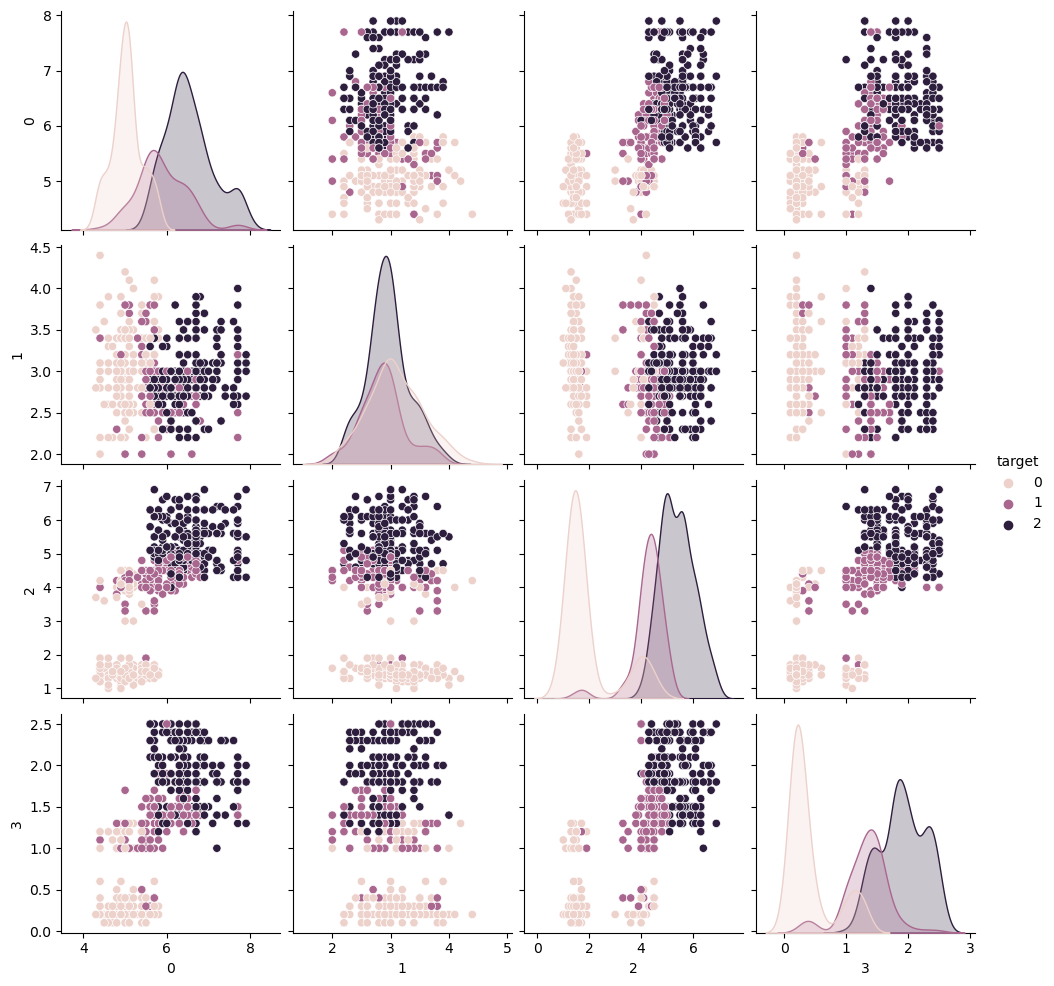

In [13]:
# Let's have a look
sns.pairplot(sdata, vars=[0,1,2,3], hue='target');